# Polarsの基礎
下記を参考に色々動かしてみる。  
適宜pandasとの違いも見る。  
https://www.pola.rs/  
https://qiita.com/_jinta/items/28442d25bba067c13bb7

In [1]:
!pip install polars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 3.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import polars as pl
import pandas as pd
import seaborn as sns
import numpy as np
import os
import math
import pyarrow as pa
import pyarrow.parquet as pq
import itertools
from pathlib import Path
from glob import glob
from sklearn.preprocessing import StandardScaler, LabelEncoder

##  データサイエンス100本ノック（構造化データ加工編）でお試し

In [3]:
csv_files = glob('../../../100knocks-preprocess/docker/work/data/*.csv')

※下記の書き方だと、パスを純粋な文字列ではなくPosixPathとして取得するので、  
若干取り扱いが面倒になる。

In [31]:
# データがあるディレクトリへのパス指定
# csv_files = Path('../../../100knocks-preprocess/docker/work/data/').glob('*.csv')
#csv_list = [os.path.split(file) for file in paths]

In [4]:
list(csv_files)

['../../../100knocks-preprocess/docker/work/data/store.csv',
 '../../../100knocks-preprocess/docker/work/data/receipt.csv',
 '../../../100knocks-preprocess/docker/work/data/category.csv',
 '../../../100knocks-preprocess/docker/work/data/product.csv',
 '../../../100knocks-preprocess/docker/work/data/customer.csv',
 '../../../100knocks-preprocess/docker/work/data/geocode.csv']

In [5]:
dtypes = {
    'customer_id': str,
    'gender_cd': str,
    'postal_cd': str,
    'application_store_cd': str,
    'status_cd': str,
    'category_major_cd': str,
    'category_medium_cd': str,
    'category_small_cd': str,
    'product_cd': str,
    'store_cd': str,
    'prefecture_cd': str,
    'tel_no': str,
    'postal_cd': str,
    'street': str,
    'application_date': str,
    'birth_day': pl.Date
}

# 複数のdfを辞書型に格納。理由はcsvごとに変数名ベタ打ちするのが嫌だから。
df_dict = {}
for file in csv_files:
    file_name = file.split('/')[-1][:-4]
    df_dict[file_name] = pl.read_csv(file)


In [6]:
# レシートデータの先頭10件を確認
df_dict['receipt'].head(10)

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001...","""P070305012""",1,158
20181118,1542499200,"""S13008""",1132,2,"""CS008415000097...","""P070701017""",1,81
20170712,1499817600,"""S14028""",1102,1,"""CS028414000014...","""P060101005""",1,170
20190205,1549324800,"""S14042""",1132,1,"""ZZ000000000000...","""P050301001""",1,25
20180821,1534809600,"""S14025""",1102,2,"""CS025415000050...","""P060102007""",1,90
20190605,1559692800,"""S13003""",1112,1,"""CS003515000195...","""P050102002""",1,138
20181205,1543968000,"""S14024""",1102,2,"""CS024514000042...","""P080101005""",1,30
20190922,1569110400,"""S14040""",1102,1,"""CS040415000178...","""P070501004""",1,128
20170504,1493856000,"""S13020""",1112,2,"""ZZ000000000000...","""P071302010""",1,770


In [122]:
# indexはないが、pandasのように書くことも可能。iloc,locは存在しない。
df_dict['receipt'][0:5]

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001...","""P070305012""",1,158
20181118,1542499200,"""S13008""",1132,2,"""CS008415000097...","""P070701017""",1,81
20170712,1499817600,"""S14028""",1102,1,"""CS028414000014...","""P060101005""",1,170
20190205,1549324800,"""S14042""",1132,1,"""ZZ000000000000...","""P050301001""",1,25
20180821,1534809600,"""S14025""",1102,2,"""CS025415000050...","""P060102007""",1,90


In [123]:
df_dict['receipt'].columns

['sales_ymd',
 'sales_epoch',
 'store_cd',
 'receipt_no',
 'receipt_sub_no',
 'customer_id',
 'product_cd',
 'quantity',
 'amount']

In [117]:
# 任意の列を選択して表示。.selectを使うのが推奨。
cols = ['sales_ymd','customer_id', 'product_cd', 'amount']
df_dict['receipt'].select(cols).head(10)

sales_ymd,customer_id,product_cd,amount
i64,str,str,i64
20181103,"""CS006214000001...","""P070305012""",158
20181118,"""CS008415000097...","""P070701017""",81
20170712,"""CS028414000014...","""P060101005""",170
20190205,"""ZZ000000000000...","""P050301001""",25
20180821,"""CS025415000050...","""P060102007""",90
20190605,"""CS003515000195...","""P050102002""",138
20181205,"""CS024514000042...","""P080101005""",30
20190922,"""CS040415000178...","""P070501004""",128
20170504,"""ZZ000000000000...","""P071302010""",770


In [127]:
# .filterはpandasの.queryみたいな感じ。pl.col(列名)で列を選択する。locの列指定みたいな感じ。
df_dict['receipt'].filter(pl.col('amount') > 200).head()

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20170504,1493856000,"""S13020""",1112,2,"""ZZ000000000000...","""P071302010""",1,770
20191010,1570665600,"""S14027""",1102,1,"""CS027514000015...","""P071101003""",1,680
20171010,1507593600,"""S14021""",1162,1,"""CS021515000126...","""P040402001""",1,228
20180506,1525564800,"""S13039""",1112,1,"""CS039414000052...","""P059001019""",1,428
20190326,1553558400,"""S13016""",112,1,"""CS016215000032...","""P091401190""",1,780


In [130]:
# 複数条件
df_dict['receipt'].filter( (pl.col('amount') > 200) & (pl.col('quantity') > 1) ).head()

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20170616,1497571200,"""S12030""",1182,2,"""CS030515000078...","""P040503001""",2,596
20191017,1571270400,"""S13004""",1182,2,"""CS004413000039...","""P071401002""",2,2200
20180607,1528329600,"""S14022""",1112,2,"""CS022512000070...","""P050603001""",2,336
20180607,1528329600,"""S14045""",1142,2,"""ZZ000000000000...","""P060303001""",2,296
20180508,1525737600,"""S13004""",112,1,"""CS004215000154...","""P060303001""",2,296


In [134]:
# 条件を変数に格納してフィルタリングも可能。
condition = (pl.col('amount') > 200) & (pl.col('quantity') > 1)
df_dict['receipt'].filter(condition).head()

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20170616,1497571200,"""S12030""",1182,2,"""CS030515000078...","""P040503001""",2,596
20191017,1571270400,"""S13004""",1182,2,"""CS004413000039...","""P071401002""",2,2200
20180607,1528329600,"""S14022""",1112,2,"""CS022512000070...","""P050603001""",2,336
20180607,1528329600,"""S14045""",1142,2,"""ZZ000000000000...","""P060303001""",2,296
20180508,1525737600,"""S13004""",112,1,"""CS004215000154...","""P060303001""",2,296


In [136]:
# 一部の列名を変更したうえで、複数列を選択
df_dict['receipt'].select([
    pl.col('sales_ymd').alias('sales_date'), 'customer_id', 'product_cd', 'amount'
]).head(10)

sales_date,customer_id,product_cd,amount
i64,str,str,i64
20181103,"""CS006214000001...","""P070305012""",158
20181118,"""CS008415000097...","""P070701017""",81
20170712,"""CS028414000014...","""P060101005""",170
20190205,"""ZZ000000000000...","""P050301001""",25
20180821,"""CS025415000050...","""P060102007""",90
20190605,"""CS003515000195...","""P050102002""",138
20181205,"""CS024514000042...","""P080101005""",30
20190922,"""CS040415000178...","""P070501004""",128
20170504,"""ZZ000000000000...","""P071302010""",770


In [140]:
#pandasのqueryに相当する捜査はselect,filterの組み合わせで行う。
df_dict['receipt'].select(cols).filter(pl.col('customer_id') == 'CS018205000001')

sales_ymd,customer_id,product_cd,amount
i64,str,str,i64
20180911,"""CS018205000001...","""P071401012""",2200
20180414,"""CS018205000001...","""P060104007""",600
20170614,"""CS018205000001...","""P050206001""",990
20170614,"""CS018205000001...","""P060702015""",108
20190216,"""CS018205000001...","""P071005024""",102
20180414,"""CS018205000001...","""P071101002""",278
20190226,"""CS018205000001...","""P070902035""",168
20190924,"""CS018205000001...","""P060805001""",495
20190226,"""CS018205000001...","""P071401020""",2200


In [148]:
# 顧客IDと売上金額でフィルタリング。複数条件のフィルタリングは下記のように書く。
df_dict['receipt'].select(cols).filter(
    (pl.col('customer_id') == 'CS018205000001') &
    (pl.col('amount') > 1000)
)

sales_ymd,customer_id,product_cd,amount
i64,str,str,i64
20180911,"""CS018205000001...","""P071401012""",2200
20190226,"""CS018205000001...","""P071401020""",2200
20180911,"""CS018205000001...","""P071401005""",1100


In [149]:
# もう少し複雑な場合のフィルタリング
cols = ['sales_ymd','customer_id', 'product_cd', 'quantity','amount']

df_dict['receipt'].select(cols).filter(
    (pl.col('customer_id') == 'CS018205000001') &
    ((pl.col('amount') >= 1000) | (pl.col('quantity') >= 5))
)

sales_ymd,customer_id,product_cd,quantity,amount
i64,str,str,i64,i64
20180911,"""CS018205000001...","""P071401012""",1,2200
20180414,"""CS018205000001...","""P060104007""",6,600
20170614,"""CS018205000001...","""P050206001""",5,990
20190226,"""CS018205000001...","""P071401020""",1,2200
20180911,"""CS018205000001...","""P071401005""",1,1100


In [156]:
# amountが1000以上2000以下の場合。
# .is_betweenで範囲指定する
df_dict['receipt'].select(cols).filter(
    (pl.col('customer_id') == 'CS018205000001') &
    ((pl.col('amount').is_between(1000, 2000)) | (pl.col('quantity') >= 5))
)

sales_ymd,customer_id,product_cd,quantity,amount
i64,str,str,i64,i64
20180414,"""CS018205000001...","""P060104007""",6,600
20170614,"""CS018205000001...","""P050206001""",5,990
20180911,"""CS018205000001...","""P071401005""",1,1100


下記のようなpandasのqueryのような書き方はできず、エラーになる。  
.is_betweenはあまり直感的ではないけど、慣れの問題かも。

In [150]:
# df_dict['receipt'].select(cols).filter(
#     (pl.col('customer_id') == 'CS018205000001') &
#     (1000 <= pl.col('amount') <= 2000)
# )

ValueError: Since Expr are lazy, the truthiness of an Expr is ambiguous. Hint: use '&' or '|' to logically combine Expr, not 'and'/'or', and use 'x.is_in([y,z])' instead of 'x in [y,z]' to check membership.

In [159]:
#店舗データ（df_store）から、店舗コード（store_cd）が"S14"で始まるものだけ全項目抽出し、5件表示
df_dict['store'].filter(pl.col('store_cd').str.starts_with('S14')).head(5)

store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
str,str,str,str,str,str,str,f64,f64,f64
"""S14010""","""菊名店""","""14""","""神奈川県""","""神奈川県横浜市港北区菊名一丁...","""カナガワケンヨコハマシコウホ...","""045-123-4032""",139.6326,35.50049,1732.0
"""S14033""","""阿久和店""","""14""","""神奈川県""","""神奈川県横浜市瀬谷区阿久和西...","""カナガワケンヨコハマシセヤク...","""045-123-4043""",139.4961,35.45918,1495.0
"""S14036""","""相模原中央店""","""14""","""神奈川県""","""神奈川県相模原市中央二丁目""","""カナガワケンサガミハラシチュ...","""042-123-4045""",139.3716,35.57327,1679.0
"""S14040""","""長津田店""","""14""","""神奈川県""","""神奈川県横浜市緑区長津田みな...","""カナガワケンヨコハマシミドリ...","""045-123-4046""",139.4994,35.52398,1548.0
"""S14050""","""阿久和西店""","""14""","""神奈川県""","""神奈川県横浜市瀬谷区阿久和西...","""カナガワケンヨコハマシセヤク...","""045-123-4053""",139.4961,35.45918,1830.0


In [160]:
#顧客データ（df_customer）から顧客ID（customer_id）の末尾が1のものだけ全項目抽出し、5件表示
df_dict['customer'].filter(pl.col('customer_id').str.ends_with('1')).head(5)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS037613000071...","""六角 雅彦""","""9""","""不明""",1952-04-01,66,"""136-0076""","""東京都江東区南砂******...","""S13037""","""20150414""","""0-00000000-0"""
"""CS028811000001...","""堀井 かおり""","""1""","""女性""",1933-03-27,86,"""245-0016""","""神奈川県横浜市泉区和泉町**...","""S14028""","""20160115""","""0-00000000-0"""
"""CS040412000191...","""川井 郁恵""","""1""","""女性""",1977-01-05,42,"""226-0021""","""神奈川県横浜市緑区北八朔町*...","""S14040""","""20151101""","""1-20091025-4"""
"""CS028314000011...","""小菅 あおい""","""1""","""女性""",1983-11-26,35,"""246-0038""","""神奈川県横浜市瀬谷区宮沢**...","""S14028""","""20151123""","""1-20080426-5"""
"""CS039212000051...","""藤島 恵梨香""","""1""","""女性""",1997-02-03,22,"""166-0001""","""東京都杉並区阿佐谷北****...","""S13039""","""20171121""","""1-20100215-4"""


In [162]:
#店舗データ（df_store）から、住所 (address) に"横浜市"が含まれるものだけ全項目表示
df_dict['store'].filter(pl.col('address').str.contains('横浜市'))

store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
str,str,str,str,str,str,str,f64,f64,f64
"""S14010""","""菊名店""","""14""","""神奈川県""","""神奈川県横浜市港北区菊名一丁...","""カナガワケンヨコハマシコウホ...","""045-123-4032""",139.6326,35.50049,1732.0
"""S14033""","""阿久和店""","""14""","""神奈川県""","""神奈川県横浜市瀬谷区阿久和西...","""カナガワケンヨコハマシセヤク...","""045-123-4043""",139.4961,35.45918,1495.0
"""S14040""","""長津田店""","""14""","""神奈川県""","""神奈川県横浜市緑区長津田みな...","""カナガワケンヨコハマシミドリ...","""045-123-4046""",139.4994,35.52398,1548.0
"""S14050""","""阿久和西店""","""14""","""神奈川県""","""神奈川県横浜市瀬谷区阿久和西...","""カナガワケンヨコハマシセヤク...","""045-123-4053""",139.4961,35.45918,1830.0
"""S14028""","""二ツ橋店""","""14""","""神奈川県""","""神奈川県横浜市瀬谷区二ツ橋町...","""カナガワケンヨコハマシセヤク...","""045-123-4042""",139.4963,35.46304,1574.0
"""S14012""","""本牧和田店""","""14""","""神奈川県""","""神奈川県横浜市中区本牧和田""","""カナガワケンヨコハマシナカク...","""045-123-4034""",139.6582,35.42156,1341.0
"""S14046""","""北山田店""","""14""","""神奈川県""","""神奈川県横浜市都筑区北山田一...","""カナガワケンヨコハマシツヅキ...","""045-123-4049""",139.5916,35.56189,831.0
"""S14011""","""日吉本町店""","""14""","""神奈川県""","""神奈川県横浜市港北区日吉本町...","""カナガワケンヨコハマシコウホ...","""045-123-4033""",139.6316,35.54655,890.0
"""S14048""","""中川中央店""","""14""","""神奈川県""","""神奈川県横浜市都筑区中川中央...","""カナガワケンヨコハマシツヅキ...","""045-123-4051""",139.5758,35.54912,1657.0


In [163]:
#顧客データ（df_customer）から、ステータスコード（status_cd）の先頭がアルファベットのA〜Fで始まるデータを全項目抽出し、5件表示
#containsには正規表現も使用可能
df_dict['customer'].filter(pl.col('status_cd').str.contains(r'^[A-F]')).head(5)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS031415000172...","""宇多田 貴美子""","""1""","""女性""",1976-10-04,42,"""151-0053""","""東京都渋谷区代々木*****...","""S13031""","""20150529""","""D-20100325-C"""
"""CS015414000103...","""奥野 陽子""","""1""","""女性""",1977-08-09,41,"""136-0073""","""東京都江東区北砂******...","""S13015""","""20150722""","""B-20100609-B"""
"""CS011215000048...","""芦田 沙耶""","""1""","""女性""",1992-02-01,27,"""223-0062""","""神奈川県横浜市港北区日吉本町...","""S14011""","""20150228""","""C-20100421-9"""
"""CS029415000023...","""梅田 里穂""","""1""","""女性""",1976-01-17,43,"""279-0043""","""千葉県浦安市富士見*****...","""S12029""","""20150610""","""D-20100918-E"""
"""CS035415000029...","""寺沢 真希""","""9""","""不明""",1977-09-27,41,"""158-0096""","""東京都世田谷区玉川台****...","""S13035""","""20141220""","""F-20101029-F"""


In [165]:
#顧客データ（df_customer）から、ステータスコード（status_cd）の末尾が数字の1〜9で終わるデータを全項目抽出し、5件表示せよ。
df_dict['customer'].filter(pl.col('status_cd').str.contains(r'[1-9]$')).head(5)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS001215000145...","""田崎 美紀""","""1""","""女性""",1995-03-29,24,"""144-0055""","""東京都大田区仲六郷*****...","""S13001""","""20170605""","""6-20090929-2"""
"""CS033513000180...","""安斎 遥""","""1""","""女性""",1962-07-11,56,"""241-0823""","""神奈川県横浜市旭区善部町**...","""S14033""","""20150728""","""6-20080506-5"""
"""CS011215000048...","""芦田 沙耶""","""1""","""女性""",1992-02-01,27,"""223-0062""","""神奈川県横浜市港北区日吉本町...","""S14011""","""20150228""","""C-20100421-9"""
"""CS040412000191...","""川井 郁恵""","""1""","""女性""",1977-01-05,42,"""226-0021""","""神奈川県横浜市緑区北八朔町*...","""S14040""","""20151101""","""1-20091025-4"""
"""CS009315000023...","""皆川 文世""","""1""","""女性""",1980-04-15,38,"""154-0012""","""東京都世田谷区駒沢*****...","""S13009""","""20150319""","""5-20080322-1"""


In [167]:
#顧客データ（df_customer）から、ステータスコード（status_cd）の先頭がアルファベットのA〜Fで始まり、末尾が数字の1〜9で終わるデータを全項目抽出し、5件表示せよ。
df_dict['customer'].filter(pl.col('status_cd').str.contains(r'^[A-F].*[1-9]$')).head(5)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS011215000048...","""芦田 沙耶""","""1""","""女性""",1992-02-01,27,"""223-0062""","""神奈川県横浜市港北区日吉本町...","""S14011""","""20150228""","""C-20100421-9"""
"""CS022513000105...","""島村 貴美子""","""1""","""女性""",1962-03-12,57,"""249-0002""","""神奈川県逗子市山の根****...","""S14022""","""20150320""","""A-20091115-7"""
"""CS001515000096...","""水野 陽子""","""9""","""不明""",1960-11-29,58,"""144-0053""","""東京都大田区蒲田本町****...","""S13001""","""20150614""","""A-20100724-7"""
"""CS013615000053...","""西脇 季衣""","""1""","""女性""",1953-10-18,65,"""261-0026""","""千葉県千葉市美浜区幕張西**...","""S12013""","""20150128""","""B-20100329-6"""
"""CS020412000161...","""小宮 薫""","""1""","""女性""",1974-05-21,44,"""174-0042""","""東京都板橋区東坂下*****...","""S13020""","""20150822""","""B-20081021-3"""


In [168]:
#店舗データ（df_store）から、電話番号（tel_no）が3桁-3桁-4桁のデータを全項目表示せよ。
df_dict['store'].filter(pl.col('tel_no').str.contains(r'^[0-9]{3}-[0-9]{3}-[0-9]{4}$')).head(5)

store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
str,str,str,str,str,str,str,f64,f64,f64
"""S12014""","""千草台店""","""12""","""千葉県""","""千葉県千葉市稲毛区千草台一丁...","""チバケンチバシイナゲクチグサ...","""043-123-4003""",140.118,35.63559,1698.0
"""S13002""","""国分寺店""","""13""","""東京都""","""東京都国分寺市本多二丁目""","""トウキョウトコクブンジシホン...","""042-123-4008""",139.4802,35.70566,1735.0
"""S14010""","""菊名店""","""14""","""神奈川県""","""神奈川県横浜市港北区菊名一丁...","""カナガワケンヨコハマシコウホ...","""045-123-4032""",139.6326,35.50049,1732.0
"""S14033""","""阿久和店""","""14""","""神奈川県""","""神奈川県横浜市瀬谷区阿久和西...","""カナガワケンヨコハマシセヤク...","""045-123-4043""",139.4961,35.45918,1495.0
"""S14036""","""相模原中央店""","""14""","""神奈川県""","""神奈川県相模原市中央二丁目""","""カナガワケンサガミハラシチュ...","""042-123-4045""",139.3716,35.57327,1679.0


In [171]:
#顧客データ（df_customer）を生年月日（birth_day）で高齢順にソートし、先頭から全項目を5件表示せよ。
df_dict['customer'].sort('birth_day').head(5)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS003813000014...","""村山 菜々美""","""1""","""女性""",1928-11-26,90,"""182-0007""","""東京都調布市菊野台*****...","""S13003""","""20160214""","""0-00000000-0"""
"""CS026813000004...","""吉村 朝陽""","""1""","""女性""",1928-12-14,90,"""251-0043""","""神奈川県藤沢市辻堂元町***...","""S14026""","""20150723""","""0-00000000-0"""
"""CS018811000003...","""熊沢 美里""","""1""","""女性""",1929-01-07,90,"""204-0004""","""東京都清瀬市野塩******...","""S13018""","""20150403""","""0-00000000-0"""
"""CS027803000004...","""内村 拓郎""","""0""","""男性""",1929-01-12,90,"""251-0031""","""神奈川県藤沢市鵠沼藤が谷**...","""S14027""","""20151227""","""0-00000000-0"""
"""CS013801000003...","""天野 拓郎""","""0""","""男性""",1929-01-15,90,"""274-0824""","""千葉県船橋市前原東*****...","""S12013""","""20160120""","""0-00000000-0"""


In [174]:
#顧客データ（df_customer）を生年月日（birth_day）で若い順にソートし、先頭から全項目を10件表示せよ。
# reverse=Trueにすることで降順にならべる
df_dict['customer'].sort('birth_day', reverse=True).head(5)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS035114000004...","""大村 美里""","""1""","""女性""",2007-11-25,11,"""156-0053""","""東京都世田谷区桜******...","""S13035""","""20150619""","""6-20091205-6"""
"""CS022103000002...","""福山 はじめ""","""9""","""不明""",2007-10-02,11,"""249-0006""","""神奈川県逗子市逗子*****...","""S14022""","""20160909""","""0-00000000-0"""
"""CS002113000009...","""柴田 真悠子""","""1""","""女性""",2007-09-17,11,"""184-0014""","""東京都小金井市貫井南町***...","""S13002""","""20160304""","""0-00000000-0"""
"""CS004115000014...","""松井 京子""","""1""","""女性""",2007-08-09,11,"""165-0031""","""東京都中野区上鷺宮*****...","""S13004""","""20161120""","""1-20081231-1"""
"""CS002114000010...","""山内 遥""","""1""","""女性""",2007-06-03,11,"""184-0015""","""東京都小金井市貫井北町***...","""S13002""","""20160920""","""6-20100510-1"""


In [176]:
#レシート明細データ（df_receipt）に対し、1件あたりの売上金額（amount）が高い順にランクを付与し、先頭から10件表示せよ。
#項目は顧客ID（customer_id）、売上金額（amount）、付与したランクを表示させること。なお、売上金額（amount）が等しい場合は同一順位を付与するものとする。
df_dict['receipt'].select([
    pl.col('customer_id'),
    pl.col('amount'),
    pl.col('amount').rank(method='min', reverse=True).alias('ranking')
]).sort('ranking').head(10)


customer_id,amount,ranking
str,i64,u32
"""CS011415000006...",10925,1
"""ZZ000000000000...",6800,2
"""CS028605000002...",5780,3
"""CS015515000034...",5480,4
"""ZZ000000000000...",5480,4
"""ZZ000000000000...",5480,4
"""ZZ000000000000...",5440,7
"""CS021515000089...",5440,7
"""CS015515000083...",5280,9


※rankメソッドについて  
デフォルトでは'amount'の昇順（小さいものから順に）にランク付けされるため、  
reverse=Trueにして降順にランク付けしている。ランク順に表示されるわけではないので最後にsortする必要あり。  
引数methodは同一値（重複値）の処理を指定するもので、  
method='min'とすると最小値が順位となる。1位、2位タイ、2位タイ、4位のようにしたいときに使う。  
参考：https://note.nkmk.me/python-pandas-rank/

In [178]:
# Datarfame長をカウント。pandasと同じ
len(df_dict['receipt'])

104681

In [147]:
#レシート明細データ（df_receipt）の顧客ID（customer_id）に対し、ユニーク件数をカウントせよ。
df_dict['receipt'].select(pl.col('customer_id').n_unique())

customer_id
u32
8307


In [154]:
#レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）と売上数量（quantity）を合計せよ。
df_dict['receipt'].groupby('store_cd').agg([
    pl.col('amount').sum(),
    pl.col('quantity').sum()
]).sort('store_cd').head(5)

store_cd,amount,quantity
str,i64,i64
"""S12007""",638761,2099
"""S12013""",787513,2425
"""S12014""",725167,2358
"""S12029""",794741,2555
"""S12030""",684402,2403


groupbyしてから、指定列で集計したいときはaggを使う。pandasも同様。

In [157]:
#レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに最も新しい売上年月日（sales_ymd）を求め、10件表示せよ。
df_dict['receipt'].groupby('customer_id').agg([
    pl.col('sales_ymd').max()
]).sort('customer_id').head(10)

customer_id,sales_ymd
str,i64
"""CS001113000004...",20190308
"""CS001114000005...",20190731
"""CS001115000010...",20190405
"""CS001205000004...",20190625
"""CS001205000006...",20190224
"""CS001211000025...",20190322
"""CS001212000027...",20170127
"""CS001212000031...",20180906
"""CS001212000046...",20170811


In [158]:
#レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに最も古い売上年月日（sales_ymd）を求め、10件表示せよ。
df_dict['receipt'].groupby('customer_id').agg([
    pl.col('sales_ymd').min()
]).sort('customer_id').head(10)

customer_id,sales_ymd
str,i64
"""CS001113000004...",20190308
"""CS001114000005...",20180503
"""CS001115000010...",20171228
"""CS001205000004...",20170914
"""CS001205000006...",20180207
"""CS001211000025...",20190322
"""CS001212000027...",20170127
"""CS001212000031...",20180906
"""CS001212000046...",20170811


In [160]:
#レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに最も新しい売上年月日（sales_ymd）と古い売上年月日を求め、
#両者が異なるデータを10件表示せよ。
df_dict['receipt'].groupby('customer_id').agg([
    pl.col('sales_ymd').max().alias('sales_ymd_min'),
    pl.col('sales_ymd').min().alias('sales_ymd_max')
]).filter(
    pl.col('sales_ymd_min') != pl.col('sales_ymd_max')
).head(10)

customer_id,sales_ymd_min,sales_ymd_max
str,i64,i64
"""CS023515000140...",20190501,20170131
"""CS016214000015...",20190930,20170606
"""CS039415000065...",20191029,20170117
"""CS009314000030...",20190910,20170118
"""CS013615000053...",20190329,20180830
"""CS009515000113...",20191002,20170505
"""CS020515000228...",20190815,20170704
"""CS035415000213...",20190622,20170323
"""CS011415000193...",20190915,20170209


In [161]:
#レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の平均を計算し、降順でTOP5を表示せよ。
df_dict['receipt'].groupby('store_cd').agg([
    pl.col('amount').mean()
]).sort('amount', reverse=True).head(5)

store_cd,amount
str,f64
"""S13052""",402.86747
"""S13015""",351.11196
"""S13003""",350.915519
"""S14010""",348.791262
"""S13001""",348.470386


In [171]:
#レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに商品コード（product_cd）の最頻値を求め、10件表示させよ。
df_dict['receipt'].groupby('store_cd').agg([
    pl.col('product_cd').mode()
]).head(20)

store_cd,product_cd
str,list[str]
"""S13032""","[""P060303001""]"
"""S14042""","[""P050101001""]"
"""S13035""","[""P040503001""]"
"""S14033""","[""P071401001""]"
"""S14036""","[""P040503001"", ""P060101001""]"
"""S14026""","[""P071401001""]"
"""S13017""","[""P060101002""]"
"""S13039""","[""P071401001""]"
"""S14024""","[""P060303001""]"


最頻値は複数該当する可能性があるので、上記のようにリストで返ってくる。  
このリストから最初の要素を選んで表示させるには下記のように書く。

In [172]:
df_dict['receipt'].groupby('store_cd').agg([
    pl.col('product_cd').mode()
]).select([
    'store_cd',
    pl.col('product_cd').arr.first()
]).sort('store_cd').head(10)

store_cd,product_cd
str,str
"""S12007""","""P060303001"""
"""S12013""","""P060303001"""
"""S12014""","""P060303001"""
"""S12029""","""P060303001"""
"""S12030""","""P060303001"""
"""S13001""","""P060303001"""
"""S13002""","""P060303001"""
"""S13003""","""P071401001"""
"""S13004""","""P060303001"""


arr.firstはリストから一つ目の要素を取り出す処理。

In [178]:
#レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の分散を計算し、降順で5件表示せよ。
df_dict['receipt'].groupby('store_cd').agg([
    pl.col('amount').var(ddof=1)
]).sort('amount', reverse=True).head(5)

store_cd,amount
str,f64
"""S13052""",441863.252526
"""S14011""",306442.242432
"""S14034""",297068.39274
"""S13001""",295558.842618
"""S13015""",295427.197086


※分散.var()について。  
ddof(Degrees of freedom,自由度)に何もしていしないと、ddof=1となり、不偏分散が計算される。  
普通の分散にしたいならddof=0にする。  
https://pola-rs.github.io/polars/py-polars/html/reference/expressions/api/polars.Expr.var.html


In [179]:
#レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の標準偏差を計算し、降順で5件表示せよ。
df_dict['receipt'].groupby('store_cd').agg([
    pl.col('amount').std(ddof=1)
]).sort('amount', reverse=True).head(5)


store_cd,amount
str,f64
"""S13052""",664.727954
"""S14011""",553.572256
"""S14034""",545.039808
"""S13001""",543.653237
"""S13015""",543.532149


ddofの意味は分散と同様。通常の分散の平方根か、不偏分散の平方根を計算するかで決める。

In [180]:
#レシート明細データ（df_receipt）の売上金額（amount）について、25％刻みでパーセンタイル値を求めよ。
target_col = 'amount'
df_dict['receipt'].select([
    pl.col(target_col).quantile(0).alias('q_0'),
    pl.col(target_col).quantile(0.25).alias('q_25'),
    pl.col(target_col).quantile(0.50).alias('q_50'),
    pl.col(target_col).quantile(0.75).alias('q_75'),
    pl.col(target_col).quantile(1).alias('q_100'),
])

q_0,q_25,q_50,q_75,q_100
f64,f64,f64,f64,f64
10.0,102.0,170.0,288.0,10925.0


下記のようにselect文中にfor文を混ぜてすっきり書くこともできる。

In [191]:
df_dict['receipt'].select([
    pl.col(target_col).quantile(i).alias(f'q_{i*100:.0f}') for i in np.linspace(0.0,1.0,5)
])

q_0,q_25,q_50,q_75,q_100
f64,f64,f64,f64,f64
10.0,102.0,170.0,288.0,10925.0


In [193]:
#レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の平均を計算し、330以上のものを抽出せよ。
df_dict['receipt'].groupby('store_cd').agg([
    pl.col('amount').mean().alias('amount_mean')
]).filter(
    pl.col('amount_mean') >= 330
)

store_cd,amount_mean
str,f64
"""S13001""",348.470386
"""S13052""",402.86747
"""S13004""",330.943949
"""S14045""",330.082073
"""S13003""",350.915519
"""S14010""",348.791262
"""S12013""",330.19413
"""S14011""",335.718333
"""S14026""",332.340588


In [61]:
#レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに売上金額（amount）を合計して全顧客の平均を求めよ。  
#ただし、顧客IDが"Z"から始まるものは非会員を表すため、除外して計算すること。
df_dict['receipt'].filter(
    pl.col('customer_id').str.starts_with('Z').is_not()
).groupby('customer_id').agg(
    pl.col('amount').sum()
).select(
    pl.col('amount').mean()
)

amount
f64
2547.742235


In [82]:
# レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに売上金額（amount）を合計して全顧客の平均を求め、平均以上に買い物をしている顧客を抽出し、
# 10件表示せよ。ただし、顧客IDが"Z"から始まるものは非会員を表すため、除外して計算すること。
(df_dict['receipt']
    .filter(pl.col('customer_id').str.starts_with('Z').is_not()).groupby('customer_id')
    .agg(pl.col('amount').sum())
    .with_columns(pl.col('amount').mean().alias('ave_amount'))
    .filter(pl.col('amount') >= pl.col('ave_amount'))
    .sort('amount', reverse=True)
    .head(10)
)

customer_id,amount,ave_amount
str,i64,f64
"""CS017415000097...",23086,2547.742235
"""CS015415000185...",20153,2547.742235
"""CS031414000051...",19202,2547.742235
"""CS028415000007...",19127,2547.742235
"""CS001605000009...",18925,2547.742235
"""CS010214000010...",18585,2547.742235
"""CS016415000141...",18372,2547.742235
"""CS006515000023...",18372,2547.742235
"""CS011414000106...",18338,2547.742235


上記のように()で書き始めると、改行のバックスラッシュが不要になる上にきれいに見える。

In [84]:
#レシート明細データ（df_receipt）と店舗データ（df_store）を内部結合し、レシート明細データの全項目と店舗データの店舗名（store_name）を10件表示せよ。
df_dict['receipt'].head(2)

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001...","""P070305012""",1,158
20181118,1542499200,"""S13008""",1132,2,"""CS008415000097...","""P070701017""",1,81


In [85]:
df_dict['store'].head(2)

store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
str,str,str,str,str,str,str,f64,f64,f64
"""S12014""","""千草台店""","""12""","""千葉県""","""千葉県千葉市稲毛区千草台一丁...","""チバケンチバシイナゲクチグサ...","""043-123-4003""",140.118,35.63559,1698.0
"""S13002""","""国分寺店""","""13""","""東京都""","""東京都国分寺市本多二丁目""","""トウキョウトコクブンジシホン...","""042-123-4008""",139.4802,35.70566,1735.0


レシート明細と店舗データを紐づけるにはstore_cdでお互いを紐づける必要がある。  
→inner join（積集合）をとる

In [86]:
df_dict['receipt'].join(
    df_dict['store'].select(['store_cd', 'store_name']),
    how='inner',
    on='store_cd'
).head()

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount,store_name
i64,i64,str,i64,i64,str,str,i64,i64,str
20181103,1541203200,"""S14006""",112,1,"""CS006214000001...","""P070305012""",1,158,"""葛が谷店"""
20181118,1542499200,"""S13008""",1132,2,"""CS008415000097...","""P070701017""",1,81,"""成城店"""
20170712,1499817600,"""S14028""",1102,1,"""CS028414000014...","""P060101005""",1,170,"""二ツ橋店"""
20190205,1549324800,"""S14042""",1132,1,"""ZZ000000000000...","""P050301001""",1,25,"""新山下店"""
20180821,1534809600,"""S14025""",1102,2,"""CS025415000050...","""P060102007""",1,90,"""大和店"""


レシート明細と店舗データのstore_cdをキーに積集合をとり、store_nameのカラムを付け足す。

In [89]:
#商品データ（df_product）とカテゴリデータ（df_category）を内部結合し、商品データの全項目とカテゴリデータのカテゴリ小区分名（category_small_name）を10件表示せよ。
df_dict['product'].head(2)

product_cd,category_major_cd,category_medium_cd,category_small_cd,unit_price,unit_cost
str,str,str,str,i64,i64
"""P040101001""","""04""","""0401""","""040101""",198,149
"""P040101002""","""04""","""0401""","""040101""",218,164


In [90]:
df_dict['category'].head(2)

category_major_cd,category_major_name,category_medium_cd,category_medium_name,category_small_cd,category_small_name
str,str,str,str,str,str
"""04""","""惣菜""","""0401""","""御飯類""","""040101""","""弁当類"""
"""04""","""惣菜""","""0401""","""御飯類""","""040102""","""寿司類"""


-----------------------------

In [92]:
df_dict['product'].join(
    df_dict['category'].select(['category_small_cd', 'category_small_name']),
    how='inner',
    on='category_small_cd'
).head(10)

product_cd,category_major_cd,category_medium_cd,category_small_cd,unit_price,unit_cost,category_small_name
str,str,str,str,i64,i64,str
"""P040101001""","""04""","""0401""","""040101""",198,149,"""弁当類"""
"""P040101002""","""04""","""0401""","""040101""",218,164,"""弁当類"""
"""P040101003""","""04""","""0401""","""040101""",230,173,"""弁当類"""
"""P040101004""","""04""","""0401""","""040101""",248,186,"""弁当類"""
"""P040101005""","""04""","""0401""","""040101""",268,201,"""弁当類"""
"""P040101006""","""04""","""0401""","""040101""",298,224,"""弁当類"""
"""P040101007""","""04""","""0401""","""040101""",338,254,"""弁当類"""
"""P040101008""","""04""","""0401""","""040101""",420,315,"""弁当類"""
"""P040101009""","""04""","""0401""","""040101""",498,374,"""弁当類"""


In [95]:
# 顧客データ（df_customer）とレシート明細データ（df_receipt）から、顧客ごとの売上金額合計を求め、10件表示せよ。ただし、売上実績がない顧客については売上金額を0として表示させること。
# また、顧客は性別コード（gender_cd）が女性（1）であるものを対象とし、非会員（顧客IDが"Z"から始まるもの）は除外すること。
df_dict['customer'].head(2)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS021313000114...","""大野 あや子""","""1""","""女性""",1981-04-29,37,"""259-1113""","""神奈川県伊勢原市粟窪****...","""S14021""","""20150905""","""0-00000000-0"""
"""CS037613000071...","""六角 雅彦""","""9""","""不明""",1952-04-01,66,"""136-0076""","""東京都江東区南砂******...","""S13037""","""20150414""","""0-00000000-0"""


In [103]:
df_dict['receipt'].head(2)

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001...","""P070305012""",1,158
20181118,1542499200,"""S13008""",1132,2,"""CS008415000097...","""P070701017""",1,81


In [109]:
df_dict['receipt'].head(1).get_column('customer_id').item()

'CS006214000001'

In [118]:
(df_dict['customer']
    .filter( (pl.col('customer_id').str.starts_with('Z').is_not()) & 
             (pl.col('gender_cd') == "1") )
    .join(
        df_dict['receipt'].select(['customer_id','amount']),
        how = 'inner',
        on = 'customer_id')
    .groupby('customer_id')
    .agg(pl.col('amount').sum().fill_null(0))
    .head(10)
)

customer_id,amount
str,i64
"""CS044315000012...",824
"""CS017515000056...",5562
"""CS040614000022...",210
"""CS034615000052...",1220
"""CS021214000036...",788
"""CS028612000055...",1108
"""CS001415000480...",6635
"""CS025415000208...",3609
"""CS010215000056...",626


how = 'inner'では一致するキーに対応する行全てが結合される。  
顧客データの顧客ID一つに対して、レシートデータの顧客IDは複数対応するため、  
全て結合される。  
結合した結果nullになるものはfill_null(置き換えたい値)で置換できる。  

In [123]:
(df_dict['customer']
    .filter( (pl.col('customer_id').str.starts_with('Z').is_not()) & 
             (pl.col('gender_cd') == "1") )
    .join(
        df_dict['receipt'].select(['customer_id','amount']),
        how = 'inner',
        on = 'customer_id')
    .filter(pl.col('customer_name') == "中田 光")
).head(3)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,amount
str,str,str,str,date,i64,str,str,str,str,str,i64
"""CS008415000097...","""中田 光""","""1""","""女性""",1971-05-21,47,"""182-0004""","""東京都調布市入間町*****...","""S13008""","""20150322""","""9-20100417-B""",81
"""CS008415000097...","""中田 光""","""1""","""女性""",1971-05-21,47,"""182-0004""","""東京都調布市入間町*****...","""S13008""","""20150322""","""9-20100417-B""",538
"""CS008415000097...","""中田 光""","""1""","""女性""",1971-05-21,47,"""182-0004""","""東京都調布市入間町*****...","""S13008""","""20150322""","""9-20100417-B""",248


In [126]:
df_dict['receipt'].head(1)

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001...","""P070305012""",1,158


In [136]:
#レシート明細データ（df_receipt）から、売上日数の多い顧客の上位20件を抽出したデータと、
#売上金額合計の多い顧客の上位20件を抽出したデータをそれぞれ作成し、さらにその2つを完全外部結合せよ。
#ただし、非会員（顧客IDが"Z"から始まるもの）は除外すること。
df_filter = df_dict['receipt'].filter(pl.col('customer_id').str.starts_with('Z').is_not())

df1 = df_filter.groupby('customer_id').agg(
    pl.col('sales_ymd').count()
).sort('sales_ymd', reverse=True).head(20)

df2 = df_filter.groupby('customer_id').agg(
    pl.col('amount').sum()
).sort('amount', reverse=True).head(20)

df12 = df1.join(df2, how='outer', on='customer_id')


In [139]:
df12

customer_id,sales_ymd,amount
str,u32,i64
"""CS017415000097...",40,23086
"""CS015415000185...",44,20153
"""CS031414000051...",38,19202
"""CS028415000007...",42,19127
"""CS001605000009...",null,18925
"""CS010214000010...",44,18585
"""CS006515000023...",null,18372
"""CS016415000141...",40,18372
"""CS011414000106...",null,18338


完全外部結合にはouter joinを使う。  
これは２つのテーブルの共通部分、共通でない部分すべて合わせて結合する。

In [141]:
#全ての店舗と全ての商品を組み合わせたデータを作成したい。店舗データ（df_store）と商品データ（df_product）を直積し、件数を計算せよ。
df_dict['store'].head(3)

store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
str,str,str,str,str,str,str,f64,f64,f64
"""S12014""","""千草台店""","""12""","""千葉県""","""千葉県千葉市稲毛区千草台一丁...","""チバケンチバシイナゲクチグサ...","""043-123-4003""",140.118,35.63559,1698.0
"""S13002""","""国分寺店""","""13""","""東京都""","""東京都国分寺市本多二丁目""","""トウキョウトコクブンジシホン...","""042-123-4008""",139.4802,35.70566,1735.0
"""S14010""","""菊名店""","""14""","""神奈川県""","""神奈川県横浜市港北区菊名一丁...","""カナガワケンヨコハマシコウホ...","""045-123-4032""",139.6326,35.50049,1732.0


In [142]:
df_dict['product'].head(3)

product_cd,category_major_cd,category_medium_cd,category_small_cd,unit_price,unit_cost
str,str,str,str,i64,i64
"""P040101001""","""04""","""0401""","""040101""",198,149
"""P040101002""","""04""","""0401""","""040101""",218,164
"""P040101003""","""04""","""0401""","""040101""",230,173


1店舗に全ての商品が紐づくようなテーブルを作成すればよい。  
直積：集合AとBに対して、Aの要素aとBの要素bを組にした (a, b) の形の全組み合わせの集合を作ること。A×Bで表わす。

In [153]:
(df_dict['store']
    .with_columns(pl.lit(0).alias('key'))
    .join(df_dict['product'].with_columns(pl.lit(0).alias('key')), how='outer', on='key')
).shape


(531590, 17)

1店舗に全ての商品を紐づければよいので、新しく全レコード0のkey列を作成し、  
ここをキーに結合する。key列の値が２テーブルで同一なので、how='inner'でも結果は同じ。

In [156]:
#検算
len(df_dict['store']) * len(df_dict['product'])

531590

### P-041:  
レシート明細データ（df_receipt）の売上金額（amount）を日付（sales_ymd）ごとに集計し、前回売上があった日からの売上金額増減を計算せよ。そして結果を10件表示せよ。

In [160]:
df_dict['receipt'].head(1)

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001...","""P070305012""",1,158


In [167]:
(df_dict['receipt']
 .groupby('sales_ymd')
 .agg(pl.col('amount').sum())
 .sort('sales_ymd')
 .with_columns(diff_amount = pl.col('amount') - pl.col('amount').shift())
 .head(10)
)

sales_ymd,amount,diff_amount
i64,i64,i64
20170101,33723,null
20170102,24165,-9558
20170103,27503,3338
20170104,36165,8662
20170105,37830,1665
20170106,32387,-5443
20170107,23415,-8972
20170108,24737,1322
20170109,26718,1981


.shiftはデフォルトでは1行前のデータを取得する。x行前のデータを取得したい場合は引数にその数を指定する。.shirt(3) みたいな。   
使うときはデータの並びに注意。事前にsortが必要。

In [168]:
(df_dict['receipt']
 .groupby('sales_ymd')
 .agg(pl.col('amount').sum())
 .sort('sales_ymd')
 .with_columns(diff_amount = pl.col('amount').diff())
 .head(10)
)

sales_ymd,amount,diff_amount
i64,i64,i64
20170101,33723,null
20170102,24165,-9558
20170103,27503,3338
20170104,36165,8662
20170105,37830,1665
20170106,32387,-5443
20170107,23415,-8972
20170108,24737,1322
20170109,26718,1981


pandas同様にdiffメソッドも使える。こっちの方がすっきりかけるかも。  
diffでも行数を指定可能。

### P-042:  
レシート明細データ（df_receipt）の売上金額（amount）を日付（sales_ymd）ごとに集計し、各日付のデータに対し、  
前回、前々回、3回前に売上があった日のデータを結合せよ。そして結果を10件表示せよ。

In [229]:
col_names = ['sales_ymd','amount']

# 前回、前々回、3回前のデータを表すのに必要な列名、.shiftで戻る行数の組み合わせを作成
li_cols_nShift = list(itertools.product(range(1, 4), col_names))

In [230]:
li_cols_nShift

[(1, 'sales_ymd'),
 (1, 'amount'),
 (2, 'sales_ymd'),
 (2, 'amount'),
 (3, 'sales_ymd'),
 (3, 'amount')]

In [232]:
(df_dict['receipt']
 .groupby('sales_ymd')
 .agg(pl.col('amount').sum())
 .sort('sales_ymd')
 .with_columns(
     pl.col(col_name).shift(i).alias(f'{col_name}_{i}TAgo') for i, col_name in li_cols_nShift
 )
 .head(10)
)

sales_ymd,amount,sales_ymd_1TAgo,amount_1TAgo,sales_ymd_2TAgo,amount_2TAgo,sales_ymd_3TAgo,amount_3TAgo
i64,i64,i64,i64,i64,i64,i64,i64
20170101,33723,null,null,null,null,null,null
20170102,24165,20170101,33723,null,null,null,null
20170103,27503,20170102,24165,20170101,33723,null,null
20170104,36165,20170103,27503,20170102,24165,20170101,33723
20170105,37830,20170104,36165,20170103,27503,20170102,24165
20170106,32387,20170105,37830,20170104,36165,20170103,27503
20170107,23415,20170106,32387,20170105,37830,20170104,36165
20170108,24737,20170107,23415,20170106,32387,20170105,37830
20170109,26718,20170108,24737,20170107,23415,20170106,32387


### P-043：
レシート明細データ（df_receipt）と顧客データ（df_customer）を結合し、  
性別コード（gender_cd）と年代（ageから計算）ごとに売上金額（amount）を合計した売上サマリデータを作成せよ。性別コードは0が男性、1が女性、9が不明を表すものとする。  
ただし、項目構成は年代、女性の売上金額、男性の売上金額、性別不明の売上金額の4項目とすること（縦に年代、横に性別のクロス集計）。また、年代は10歳ごとの階級とすること。

In [10]:
gender_code = {'0': '男性', '1':'女性', '9':'不明'}

In [21]:
gender_code.keys()

dict_keys(['0', '1', '9'])

In [22]:
gender_code.items()

dict_items([('0', '男性'), ('1', '女性'), ('9', '不明')])

#### .applyを使った書き方

In [57]:
%%time
(df_dict['customer']
 .join(df_dict['receipt'], how='inner', on='customer_id')
 .with_columns([
     ((pl.col('age') / 10).floor() * 10 ).alias('era'), 
    pl.col('gender_cd').apply(lambda x: gender_code[x]).alias('gender')
 ])
 .groupby(['gender','era']).agg(pl.col('amount').sum())
 .pivot(values='amount', index='era', columns='gender')
 .sort('era')
)

CPU times: user 149 ms, sys: 51.8 ms, total: 201 ms
Wall time: 63.1 ms


era,女性,男性,不明
f64,i64,i64,i64
10.0,149836,1591,4317
20.0,1363724,72940,44328
30.0,693047,177322,50441
40.0,9320791,19355,483512
50.0,6685192,54320,342923
60.0,987741,272469,71418
70.0,29764,13435,2427
80.0,262923,46360,5111
90.0,6260,null,null


.pivotを使うことでクロス集計表が書ける。  
.floorは小数点以下を切り捨てるメソッド。

groupbyしなくても.pivotのaggregata_fn='sum'を指定すれば同じことができる。  
※公式ドキュメントではパラメタ名がaggregate_functionとなっているので注意。正しくは_fn。  
　https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.pivot.html#polars.DataFrame.pivot

In [413]:
%%time
(df_dict['customer']
 .join(df_dict['receipt'], how='inner', on='customer_id')
 .with_columns([
     ((pl.col('age') / 10).floor() * 10 ).alias('era'), 
    pl.col('gender_cd').apply(lambda x: gender_code[x]).alias('gender')
 ])
 .pivot(values='amount', index='era', columns='gender',aggregate_fn='sum')
 .sort('era')
)

CPU times: user 149 ms, sys: 54.4 ms, total: 203 ms
Wall time: 72.8 ms


era,女性,男性,不明
f64,i64,i64,i64
10.0,149836,1591,4317
20.0,1363724,72940,44328
30.0,693047,177322,50441
40.0,9320791,19355,483512
50.0,6685192,54320,342923
60.0,987741,272469,71418
70.0,29764,13435,2427
80.0,262923,46360,5111
90.0,6260,null,null


#### when,thenを使った書き方

.applyを使用すると内部ではRustではなくPythonの関数が呼び出され、  
速度的には劣ってしまうため、大量データを扱う際は.applyを使わないことが望ましい。（上記例ぐらいであれば問題なし）

In [58]:
gender_code

{'0': '男性', '1': '女性', '9': '不明'}

In [416]:
%%time
(df_dict['customer']
 .join(df_dict['receipt'], how='inner', on='customer_id')
 .with_columns([
     ((pl.col('age') / 10).floor() * 10 ).alias('era'), 
    pl.when(pl.col('gender_cd') == '0').then('男性')
    .when(pl.col('gender_cd') == '1').then('女性')
    .when(pl.col('gender_cd') == '9').then('不明').alias('gender')
 ])
 .pivot(values='amount', index='era', columns='gender',aggregate_fn='sum')
 .sort('era')
)

CPU times: user 96.9 ms, sys: 95.9 ms, total: 193 ms
Wall time: 46.3 ms


era,女性,男性,不明
f64,i64,i64,i64
10.0,149836,1591,4317
20.0,1363724,72940,44328
30.0,693047,177322,50441
40.0,9320791,19355,483512
50.0,6685192,54320,342923
60.0,987741,272469,71418
70.0,29764,13435,2427
80.0,262923,46360,5111
90.0,6260,null,null


上記の通り冗長な書き方にはなってしまうが、  
何回か実行して.applyの場合と比較すると、Wall timeが40%程度早くなっていそうだった。  
(2023/3/14 追記)  .Exprをチェインすれば下記のようにすっきり書ける。速度もそんなに変わらない。

In [396]:
gender_code

{'0': '男性', '1': '女性', '9': '不明'}

In [399]:
def gender_func(col:str, gender_code: dict) -> pl.Expr:
    expr = pl
    for key, val in gender_code.items():
        expr = expr.when(pl.col(col) == key).then(val)
    
    return expr

In [400]:
gender_func('gender_cd', gender_code)

In [417]:
%%time
(df_dict['customer']
 .join(df_dict['receipt'], how='inner', on='customer_id')
 .with_columns([
     ((pl.col('age') / 10).floor() * 10 ).alias('era'), 
    gender_func('gender_cd', gender_code).alias('gender')
 ])
 .pivot(values='amount', index='era', columns='gender',aggregate_fn='sum')
 .sort('era')
)

CPU times: user 151 ms, sys: 37.4 ms, total: 188 ms
Wall time: 41.6 ms


era,女性,男性,不明
f64,i64,i64,i64
10.0,149836,1591,4317
20.0,1363724,72940,44328
30.0,693047,177322,50441
40.0,9320791,19355,483512
50.0,6685192,54320,342923
60.0,987741,272469,71418
70.0,29764,13435,2427
80.0,262923,46360,5111
90.0,6260,null,null


### P-044：
043で作成した売上サマリデータ（df_sales_summary）は性別の売上を横持ちさせたものであった。  
このデータから性別を縦持ちさせ、年代、性別コード、売上金額の3項目に変換せよ。  
ただし、性別コードは男性を"00"、女性を"01"、不明を"99"とする。

In [72]:
df_dict['customer'].head(1)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS021313000114...","""大野 あや子""","""1""","""女性""",1981-04-29,37,"""259-1113""","""神奈川県伊勢原市粟窪****...","""S14021""","""20150905""","""0-00000000-0"""


In [81]:
%%time
(df_dict['customer']
 .join(df_dict['receipt'], how='inner', on='customer_id')
 .with_columns([
     ((pl.col('age') / 10).floor() * 10 ).alias('era'), 
    pl.when(pl.col('gender') == '男性').then('00')
    .when(pl.col('gender') == '女性').then('01')
    .when(pl.col('gender') == '不明').then('99').alias('gender_cd')
 ])
 .groupby(['gender','era','gender_cd']).agg(pl.col('amount').sum())
).sort(['era','gender']).head(10)

CPU times: user 101 ms, sys: 64.7 ms, total: 165 ms
Wall time: 40.2 ms


gender,era,gender_cd,amount
str,f64,str,i64
"""不明""",10.0,"""99""",4317
"""女性""",10.0,"""01""",149836
"""男性""",10.0,"""00""",1591
"""不明""",20.0,"""99""",44328
"""女性""",20.0,"""01""",1363724
"""男性""",20.0,"""00""",72940
"""不明""",30.0,"""99""",50441
"""女性""",30.0,"""01""",693047
"""男性""",30.0,"""00""",177322


### P-045:
顧客データ（df_customer）の生年月日（birth_day）は日付型でデータを保有している。  
これをYYYYMMDD形式の文字列に変換し、顧客ID（customer_id）とともに10件表示せよ。



In [86]:
df_dict['customer'].get_column('birth_day').head(10)

birth_day
date
1981-04-29
1952-04-01
1976-10-04
1933-03-27
1995-03-29
1974-09-15
1977-08-09
1973-08-17
1931-05-02


In [85]:
df_dict['customer'].select([
    'customer_id',
    pl.col('birth_day').dt.strftime("%Y%m%d").alias('birth_day_str')
]).head(10)

customer_id,birth_day_str
str,str
"""CS021313000114...","""19810429"""
"""CS037613000071...","""19520401"""
"""CS031415000172...","""19761004"""
"""CS028811000001...","""19330327"""
"""CS001215000145...","""19950329"""
"""CS020401000016...","""19740915"""
"""CS015414000103...","""19770809"""
"""CS029403000008...","""19730817"""
"""CS015804000004...","""19310502"""


pl.Expr.st.strftimeでDate/Datetime型をstrでフォーマットするのに使える。  
https://pola-rs.github.io/polars/py-polars/html/reference/expressions/api/polars.Expr.dt.strftime.html#polars.Expr.dt.strftime

### P-046:
顧客データ（df_customer）の申し込み日（application_date）はYYYYMMDD形式の文字列型でデータを保有している。  
これを日付型に変換し、顧客ID（customer_id）とともに10件表示せよ。

In [87]:
df_dict['customer'].head(1)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS021313000114...","""大野 あや子""","""1""","""女性""",1981-04-29,37,"""259-1113""","""神奈川県伊勢原市粟窪****...","""S14021""","""20150905""","""0-00000000-0"""


In [89]:
df_dict['customer'].select([
    'customer_id',
    pl.col('application_date').str.strptime(pl.Date, '%Y%m%d')
]).head(10)

customer_id,application_date
str,date
"""CS021313000114...",2015-09-05
"""CS037613000071...",2015-04-14
"""CS031415000172...",2015-05-29
"""CS028811000001...",2016-01-15
"""CS001215000145...",2017-06-05
"""CS020401000016...",2015-02-25
"""CS015414000103...",2015-07-22
"""CS029403000008...",2015-05-15
"""CS015804000004...",2015-06-07


日付型に変換するには.str.strptimeを使う。第一引数にはDate/DateTime型を指定する必要あり。

### P-047:
レシート明細データ（df_receipt）の売上日（sales_ymd）はYYYYMMDD形式の数値型でデータを保有している。  
これを日付型に変換し、レシート番号（receipt_no）、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。

In [90]:
df_dict['receipt'].head(1)

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001...","""P070305012""",1,158


In [93]:
df_dict['receipt'].select([
    'receipt_no',
    'receipt_sub_no',
    pl.col('sales_ymd').cast(pl.Utf8).str.strptime(pl.Date, '%Y%m%d')
]).head(10)

receipt_no,receipt_sub_no,sales_ymd
i64,i64,date
112,1,2018-11-03
1132,2,2018-11-18
1102,1,2017-07-12
1132,1,2019-02-05
1102,2,2018-08-21
1112,1,2019-06-05
1102,2,2018-12-05
1102,1,2019-09-22
1112,2,2017-05-04


【2023/3/7】調べた限りではint→Dateへの直接変換はできなさそうなので、一度strにキャストしてから日付型に変換する。

### P-048:
レシート明細データ（df_receipt）の売上エポック秒（sales_epoch）は数値型のUNIX秒でデータを保有している。  
これを日付型に変換し、レシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。


In [94]:
df_dict['receipt'].head(1)

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001...","""P070305012""",1,158


In [125]:
df_dict['receipt'].select([
    'receipt_no',
    'receipt_sub_no',
    pl.from_epoch(pl.col('sales_epoch'), unit='s').cast(pl.Date).alias('sales_ymd_from_epoch')
]).head(10)

receipt_no,receipt_sub_no,sales_ymd_from_epoch
i64,i64,date
112,1,2018-11-03
1132,2,2018-11-18
1102,1,2017-07-12
1132,1,2019-02-05
1102,2,2018-08-21
1112,1,2019-06-05
1102,2,2018-12-05
1102,1,2019-09-22
1112,2,2017-05-04


秒以下も出力したいときはDate型にキャストしなくてOK.  
下記の方法でも変換可能。fmt='%s'はUNIX秒を表すので注意。  
https://docs.rs/chrono/latest/chrono/format/strftime/index.html

In [102]:
df_dict['receipt'].select([
    'receipt_no', 
    'receipt_sub_no', 
    pl.col('sales_epoch').cast(pl.Utf8).str.strptime(pl.Datetime, fmt='%s')
]).head(5)

receipt_no,receipt_sub_no,sales_epoch
i64,i64,datetime[μs]
112,1,2018-11-03 00:00:00
1132,2,2018-11-18 00:00:00
1102,1,2017-07-12 00:00:00
1132,1,2019-02-05 00:00:00
1102,2,2018-08-21 00:00:00


全然μsじゃないのは何故？

### P-049:
レシート明細データ（df_receipt）の売上エポック秒（sales_epoch）を日付型に変換し、  
「年」だけ取り出してレシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。

In [127]:
df_dict['receipt'].select([
    'receipt_no',
    'receipt_sub_no',
    pl.from_epoch(pl.col('sales_epoch'), unit='s').dt.year().alias('sales_year')
]).head(10)

receipt_no,receipt_sub_no,sales_year
i64,i64,i32
112,1,2018
1132,2,2018
1102,1,2017
1132,1,2019
1102,2,2018
1112,1,2019
1102,2,2018
1102,1,2019
1112,2,2017


Datetime型およびDate型に対してdt.year()をすることにより、「年」の部分だけ取り出せる。  
https://pola-rs.github.io/polars/py-polars/html/reference/expressions/api/polars.Expr.dt.year.html

### P-050:
レシート明細データ（df_receipt）の売上エポック秒（sales_epoch）を日付型に変換し、  
「月」だけ取り出してレシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。  
なお、「月」は0埋め2桁で取り出すこと。


In [128]:
df_dict['receipt'].select([
    'receipt_no',
    'receipt_sub_no',
    pl.from_epoch(pl.col('sales_epoch'), unit='s').dt.month()
    .cast(pl.Utf8).str.zfill(2)
    .alias('sales_month')
]).head(10)

receipt_no,receipt_sub_no,sales_month
i64,i64,str
112,1,"""11"""
1132,2,"""11"""
1102,1,"""07"""
1132,1,"""02"""
1102,2,"""08"""
1112,1,"""06"""
1102,2,"""12"""
1102,1,"""09"""
1112,2,"""05"""


str.zfill(桁数)で文字列を0埋めできる。  
以下の書き方でもOK。

In [130]:
df_dict['receipt'].select([
    'receipt_no', 
    'receipt_sub_no', 
    pl.col('sales_epoch').cast(pl.Utf8)
    .str.strptime(pl.Datetime, fmt='%s')
    .dt.strftime('%m').alias('sales_month')
]).head(10)

receipt_no,receipt_sub_no,sales_month
i64,i64,str
112,1,"""11"""
1132,2,"""11"""
1102,1,"""07"""
1132,1,"""02"""
1102,2,"""08"""
1112,1,"""06"""
1102,2,"""12"""
1102,1,"""09"""
1112,2,"""05"""


エポック秒(int)→str→日付型→strに変換しているので、.from_epochの方が楽かも。

### P-051:
レシート明細データ（df_receipt）の売上エポック秒を日付型に変換し、  
「日」だけ取り出してレシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。なお、「日」は0埋め2桁で取り出すこと。

In [202]:
df_dict['receipt'].select([
    'receipt_no',
    'receipt_sub_no',
    pl.from_epoch(pl.col('sales_epoch'), unit='s').dt.day()
    .cast(pl.Utf8).str.zfill(2)
    .alias('sales_day')
]).head()

receipt_no,receipt_sub_no,sales_day
i64,i64,str
112,1,"""03"""
1132,2,"""18"""
1102,1,"""12"""
1132,1,"""05"""
1102,2,"""21"""


### P-052:
レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計の上、  
売上金額合計に対して2,000円以下を0、2,000円より大きい金額を1に二値化し、顧客ID、売上金額合計とともに10件表示せよ。  
ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

In [203]:
df_dict['receipt'].head(1)

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001""","""P070305012""",1,158


In [236]:
(df_dict['receipt']
 .filter(pl.col('customer_id').str.starts_with('Z').is_not())
 .groupby('customer_id')
 .agg(pl.col('amount').sum().alias('total_amount'))
 .sort('total_amount', reverse=True)
 .with_columns(
     pl.when(pl.col('total_amount') <= 2000).then(0).otherwise(1).alias('sales_flag')
  )
).head(10)

customer_id,total_amount,sales_flag
str,i64,i32
"""CS017415000097""",23086,1
"""CS015415000185""",20153,1
"""CS031414000051""",19202,1
"""CS028415000007""",19127,1
"""CS001605000009""",18925,1
"""CS010214000010""",18585,1
"""CS016415000141""",18372,1
"""CS006515000023""",18372,1
"""CS011414000106""",18338,1


### P-053:
顧客データ（df_customer）の郵便番号（postal_cd）に対し、東京（先頭3桁が100〜209のもの）を1、それ以外のものを0に二値化せよ。  
さらにレシート明細データ（df_receipt）と結合し、全期間において売上実績のある顧客数を、作成した二値ごとにカウントせよ。

In [238]:
df_dict['customer'].head(1)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS021313000114""","""大野 あや子""","""1""","""女性""",1981-04-29,37,"""259-1113""","""神奈川県伊勢原市粟窪**********""","""S14021""","""20150905""","""0-00000000-0"""


In [287]:
df_dict['receipt'].head(1)

sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
i64,i64,str,i64,i64,str,str,i64,i64
20181103,1541203200,"""S14006""",112,1,"""CS006214000001""","""P070305012""",1,158


In [290]:
df_dict['customer'].with_columns(
    # 3文字目までスライシング→intにキャスト→is_betweenで判定。
    pl.when(
        pl.col('postal_cd').str.slice(0, 3).cast(pl.UInt64).is_between(100, 209)
    )
    .then(1).otherwise(0).alias('is_Tokyo')
).join(
    df_dict['receipt'], on='customer_id', how='inner'
).groupby('is_Tokyo').agg(
    pl.col('customer_id').n_unique()
)

is_Tokyo,customer_id
i32,u32
0,3906
1,4400


.n_unique()でユニークな値をカウントできる。

#### .str.メソッドの正規表現対応について
starts_withは正規表現に対応していない模様。  
また、containsは正規表現に対応しているが、複数条件は評価してくれないっぽい。（2023/3時点）  

In [270]:
df_dict['customer'].filter(
    pl.col('postal_cd').str.starts_with(r"10[1-9]")
)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str


In [276]:
df_dict['customer'].filter(
    pl.col('postal_cd').str.contains("100 | 10[1-9] | 1[1-9][0-9] | 20[0-9]")
)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str


In [278]:
df_dict['customer'].filter(
    pl.col('postal_cd').str.contains("20[0-9]")
).head(3)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS003613000188""","""西本 めぐみ""","""1""","""女性""",1950-05-18,68,"""201-0012""","""東京都狛江市中和泉**********""","""S13003""","""20160820""","""0-00000000-0"""
"""CS003615000432""","""宇野 サンタマリア""","""1""","""女性""",1951-02-09,68,"""201-0012""","""東京都狛江市中和泉**********""","""S13003""","""20170716""","""0-00000000-0"""
"""CS041515000001""","""栗田 千夏""","""1""","""女性""",1967-01-02,52,"""206-0001""","""東京都多摩市和田**********""","""S13041""","""20160422""","""E-20100803-F"""


### P-054:
顧客データ（df_customer）の住所（address）は、埼玉県、千葉県、東京都、神奈川県のいずれかとなっている。  
都道府県毎にコード値を作成し、顧客ID、住所とともに10件表示せよ。値は埼玉県を11、千葉県を12、東京都を13、神奈川県を14とすること。

In [310]:
prefec_cd = {'埼玉県':'11', '千葉県':'12', '東京都':'13', '神奈川県':'14'}

In [294]:
df_dict['customer'].head(1)

customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,str,str,date,i64,str,str,str,str,str
"""CS021313000114""","""大野 あや子""","""1""","""女性""",1981-04-29,37,"""259-1113""","""神奈川県伊勢原市粟窪**********""","""S14021""","""20150905""","""0-00000000-0"""


In [302]:
df_dict['customer'].select([
    'customer_id',
    'address',
    pl.when(pl.col('address').str.contains('埼玉県')).then(11)
    .when(pl.col('address').str.contains('千葉県')).then(12)
    .when(pl.col('address').str.contains('東京都')).then(13)
    .when(pl.col('address').str.contains('神奈川県')).then(14)
    .alias('prefecture_cd')
]).head(10)

customer_id,address,prefecture_cd
str,str,i32
"""CS021313000114""","""神奈川県伊勢原市粟窪**********""",14
"""CS037613000071""","""東京都江東区南砂**********""",13
"""CS031415000172""","""東京都渋谷区代々木**********""",13
"""CS028811000001""","""神奈川県横浜市泉区和泉町**********""",14
"""CS001215000145""","""東京都大田区仲六郷**********""",13
"""CS020401000016""","""東京都板橋区若木**********""",13
"""CS015414000103""","""東京都江東区北砂**********""",13
"""CS029403000008""","""千葉県浦安市海楽**********""",12
"""CS015804000004""","""東京都江東区北砂**********""",13


↓別解：　.str.replaceを繰り返す方法。

In [308]:
df_dict['customer'].select([
    'customer_id',
    'address',
    pl.col('address').str.replace(r'埼玉県.*', '11')
    .str.replace(r'千葉県.*', '12')
    .str.replace(r'東京都.*', '13')
    .str.replace(r'神奈川県.*', '14')
    .cast(pl.UInt16)
    .alias('prefecture_cd')
]).head(10)


customer_id,address,prefecture_cd
str,str,u16
"""CS021313000114""","""神奈川県伊勢原市粟窪**********""",14
"""CS037613000071""","""東京都江東区南砂**********""",13
"""CS031415000172""","""東京都渋谷区代々木**********""",13
"""CS028811000001""","""神奈川県横浜市泉区和泉町**********""",14
"""CS001215000145""","""東京都大田区仲六郷**********""",13
"""CS020401000016""","""東京都板橋区若木**********""",13
"""CS015414000103""","""東京都江東区北砂**********""",13
"""CS029403000008""","""千葉県浦安市海楽**********""",12
"""CS015804000004""","""東京都江東区北砂**********""",13


### P-055:
レシート明細（df_receipt）データの売上金額（amount）を顧客ID（customer_id）ごとに合計し、その合計金額の四分位点を求めよ。  
その上で、顧客ごとの売上金額合計に対して以下の基準でカテゴリ値を作成し、顧客ID、売上金額合計とともに10件表示せよ。カテゴリ値は順に1〜4とする。

最小値以上第1四分位未満 ・・・ 1を付与  
第1四分位以上第2四分位未満 ・・・ 2を付与  
第2四分位以上第3四分位未満 ・・・ 3を付与  
第3四分位以上 ・・・ 4を付与  

In [392]:
%%time
(df_dict['receipt']
 .groupby('customer_id')
 .agg(pl.col('amount').sum().alias('total_amount'))
 .with_columns(
     pl.when(pl.col('total_amount') < pl.col('total_amount').quantile(0.25)).then(1)
     .when(pl.col('total_amount') < pl.col('total_amount').quantile(0.5)).then(2)
     .when(pl.col('total_amount') < pl.col('total_amount').quantile(0.75)).then(3)
     .otherwise(4).alias('total_amount_class')
 ).sort('customer_id').head(10)
)

CPU times: user 82.4 ms, sys: 10.7 ms, total: 93.1 ms
Wall time: 31.8 ms


customer_id,total_amount,total_amount_class
str,i64,i32
"""CS001113000004""",1298,2
"""CS001114000005""",626,2
"""CS001115000010""",3044,3
"""CS001205000004""",1988,3
"""CS001205000006""",3337,3
"""CS001211000025""",456,1
"""CS001212000027""",448,1
"""CS001212000031""",296,1
"""CS001212000046""",228,1


.whenを何度もチェインするのはif,elifを繰り返すのと同じ模様。

#### (補足) polars.Exprのチェイン

下記のようにexprにpolars(ここではpl)モジュールを入れて、  
expr.～でクエリ書く→exprに再代入を繰り返すことでも、  
polars.Exprをチェインすることができる。  
似たようなDataframe操作を繰り返し行う必要がある場合は、  
操作の外で.Exprをfor文で定義しおくことで楽に記述できる。  

In [369]:
expr = pl

In [364]:
expr

<module 'polars' from '/opt/anaconda3/lib/python3.9/site-packages/polars/__init__.py'>

In [365]:
expr = expr.when(pl.col('total_amount') < pl.col('total_amount').quantile(0.25)).then(1)

In [366]:
expr

In [367]:
expr = expr.when(pl.col('total_amount') < pl.col('total_amount').quantile(0.5)).then(2)

In [368]:
expr

上記のクエリを見る感じ、やはり.whenの後はelif的な動きになってるぽい

In [374]:
np.arange(1, 5)

array([1, 2, 3, 4])

In [384]:
qtiles = [0.25, 0.5, 0.75]
col = 'total_amount'

def quartile_split(col:str, qtiles: list) -> pl.Expr:
    expr = pl
    # .Exprのチェイン
    for n, qtile in enumerate(qtiles):
        expr = expr.when(pl.col(col) < pl.col(col).quantile(qtile)).then(n+1)
    expr = expr.otherwise(n+2).alias(col)
    return expr

In [385]:
quartile_split(col, qtiles)

クエリがチェインされているのがわかる。

In [395]:
%%time
(df_dict['receipt']
 .groupby('customer_id')
 .agg(pl.col('amount').sum().alias('total_amount'))
 .with_columns(
     quartile_split(col, qtiles).alias('total_amount_class')
 ).sort('customer_id').head(10)
)

CPU times: user 59.8 ms, sys: 17.1 ms, total: 76.9 ms
Wall time: 25.4 ms


customer_id,total_amount,total_amount_class
str,i64,i32
"""CS001113000004""",1298,2
"""CS001114000005""",626,2
"""CS001115000010""",3044,3
"""CS001205000004""",1988,3
"""CS001205000006""",3337,3
"""CS001211000025""",456,1
"""CS001212000027""",448,1
"""CS001212000031""",296,1
"""CS001212000046""",228,1


上記のように繰り返し行う操作をすっきり書くことができる。  
今回は４グループなのでそのまま書いても良いが、  
大量のグループに分類するような操作は上記の書き方が使えそう。  
.applyよりもWall timeは有利なはず。

### P-056:
顧客データ（df_customer）の年齢（age）をもとに10歳刻みで年代を算出し、顧客ID（customer_id）、生年月日（birth_day）とともに10件表示せよ。  
ただし、60歳以上は全て60歳代とすること。年代を表すカテゴリ名は任意とする。

In [14]:
df_dict['customer'].select([
    'customer_id',
    'birth_day',
    pl.when(pl.col('age') >= 60).then(60)
    .otherwise((pl.col('age') / 10).floor()*10).alias('era')
]).head(10)

customer_id,birth_day,era
str,date,f64
"""CS021313000114...",1981-04-29,30.0
"""CS037613000071...",1952-04-01,60.0
"""CS031415000172...",1976-10-04,40.0
"""CS028811000001...",1933-03-27,60.0
"""CS001215000145...",1995-03-29,20.0
"""CS020401000016...",1974-09-15,40.0
"""CS015414000103...",1977-08-09,40.0
"""CS029403000008...",1973-08-17,40.0
"""CS015804000004...",1931-05-02,60.0


otherwiseにはExprも入れられる。

### P-057:
056の抽出結果と性別コード（gender_cd）により、新たに性別×年代の組み合わせを表すカテゴリデータを作成し、10件表示せよ。  
組み合わせを表すカテゴリの値は任意とする。

In [7]:
df_dict['customer'].select([
    'customer_id',
    'birth_day',
    'age',
    pl.when(pl.col('age') >= 60).then(60)
    .otherwise((pl.col('age') / 10).floor()*10).alias('era'),
    'gender_cd'
]).with_columns(
    #(pl.col('era').cast(pl.Utf8) + '_' + pl.col('gender_cd')).alias('era_and_gender_cd')
    pl.struct(['era', 'gender_cd']).alias('era_and_gender_cd')
).head(10)

customer_id,birth_day,age,era,gender_cd,era_and_gender_cd
str,str,i64,f64,i64,struct[2]
"""CS021313000114...","""1981-04-29""",37,30.0,1,"{30.0,1}"
"""CS037613000071...","""1952-04-01""",66,60.0,9,"{60.0,9}"
"""CS031415000172...","""1976-10-04""",42,40.0,1,"{40.0,1}"
"""CS028811000001...","""1933-03-27""",86,60.0,1,"{60.0,1}"
"""CS001215000145...","""1995-03-29""",24,20.0,1,"{20.0,1}"
"""CS020401000016...","""1974-09-15""",44,40.0,0,"{40.0,0}"
"""CS015414000103...","""1977-08-09""",41,40.0,1,"{40.0,1}"
"""CS029403000008...","""1973-08-17""",45,40.0,0,"{40.0,0}"
"""CS015804000004...","""1931-05-02""",87,60.0,0,"{60.0,0}"


なんとなくstructで組み合わせを表現してみた。  
コメントアウトしているとこのように文字列結合も可。

### P-058:  
顧客データ（df_customer）の性別コード（gender_cd）をダミー変数化し、顧客ID（customer_id）とともに10件表示せよ。  

In [32]:
df_dict['customer'].to_dummies('gender_cd').head()

customer_id,customer_name,gender_cd_0,gender_cd_1,gender_cd_9,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
str,str,u8,u8,u8,str,str,i64,str,str,str,i64,str
"""CS021313000114...","""大野 あや子""",0,1,0,"""女性""","""1981-04-29""",37,"""259-1113""","""神奈川県伊勢原市粟窪****...","""S14021""",20150905,"""0-00000000-0"""
"""CS037613000071...","""六角 雅彦""",0,0,1,"""不明""","""1952-04-01""",66,"""136-0076""","""東京都江東区南砂******...","""S13037""",20150414,"""0-00000000-0"""
"""CS031415000172...","""宇多田 貴美子""",0,1,0,"""女性""","""1976-10-04""",42,"""151-0053""","""東京都渋谷区代々木*****...","""S13031""",20150529,"""D-20100325-C"""
"""CS028811000001...","""堀井 かおり""",0,1,0,"""女性""","""1933-03-27""",86,"""245-0016""","""神奈川県横浜市泉区和泉町**...","""S14028""",20160115,"""0-00000000-0"""
"""CS001215000145...","""田崎 美紀""",0,1,0,"""女性""","""1995-03-29""",24,"""144-0055""","""東京都大田区仲六郷*****...","""S13001""",20170605,"""6-20090929-2"""


In [35]:
df_dict['customer'].to_dummies('gender_cd').select([
    'customer_id',
    'gender_cd_0',
    'gender_cd_1',
    'gender_cd_9'
]).head()

customer_id,gender_cd_0,gender_cd_1,gender_cd_9
str,u8,u8,u8
"""CS021313000114...",0,1,0
"""CS037613000071...",0,0,1
"""CS031415000172...",0,1,0
"""CS028811000001...",0,1,0
"""CS001215000145...",0,1,0


### P-059:
レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、  
売上金額合計を平均0、標準偏差1に標準化して顧客ID、売上金額合計とともに10件表示せよ。  
標準化に使用する標準偏差は、分散の平方根、もしくは不偏分散の平方根のどちらでも良いものとする。  
ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

In [63]:
# pl.col('total_amount')の記述回数が多いので、変数として定義しておく。
t_amount = pl.col('total_amount')

temp = (df_dict['receipt']
    .filter(pl.col('customer_id').str.starts_with('Z').is_not())
    .groupby('customer_id').agg(pl.col('amount').sum().alias('total_amount'))
    .with_columns(
        ( ( t_amount - t_amount.mean()) / t_amount.std(ddof=1) ).alias('std_total_amount')
    ).sort('customer_id')
)
temp.head(10)

customer_id,total_amount,std_total_amount
str,i64,f64
"""CS001113000004...",1298,-0.45935
"""CS001114000005...",626,-0.706348
"""CS001115000010...",3044,0.182403
"""CS001205000004...",1988,-0.205737
"""CS001205000006...",3337,0.290096
"""CS001211000025...",456,-0.768832
"""CS001212000027...",448,-0.771773
"""CS001212000031...",296,-0.827641
"""CS001212000046...",228,-0.852635


In [66]:
# 検算
print(f"mean :{temp['std_total_amount'].mean()}")
print(f"mean :{temp['std_total_amount'].std(1)}")

mean :-1.2708885767079205e-16
mean :1.0000000000000004


### P-060:
レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、  
売上金額合計を最小値0、最大値1に正規化して顧客ID、売上金額合計とともに10件表示せよ。  
ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

In [72]:
t_amount = pl.col('total_amount')

df_result = (df_dict['receipt']
    .filter(pl.col('customer_id').str.starts_with('Z').is_not())
    .groupby('customer_id').agg(pl.col('amount').sum().alias('total_amount'))
    .with_columns(
        ( ( t_amount - t_amount.min()) / (t_amount.max() - t_amount.min()) ).alias('normalized_total_amount')
    ).sort('customer_id')
)
df_result.head(10)

customer_id,total_amount,normalized_total_amount
str,i64,f64
"""CS001113000004...",1298,0.053354
"""CS001114000005...",626,0.024157
"""CS001115000010...",3044,0.129214
"""CS001205000004...",1988,0.083333
"""CS001205000006...",3337,0.141945
"""CS001211000025...",456,0.016771
"""CS001212000027...",448,0.016423
"""CS001212000031...",296,0.009819
"""CS001212000046...",228,0.006865


In [73]:
# 確認
df_result.sort('normalized_total_amount', reverse=True).head(3)

customer_id,total_amount,normalized_total_amount
str,i64,f64
"""CS017415000097...",23086,1.0
"""CS015415000185...",20153,0.872567
"""CS031414000051...",19202,0.831248


## 特定の条件に当てはまる行だけ落とす(Polars vs Pandas)

In [125]:
# seabornからのデータセットはpandasのDataFrameの形
df_pd = sns.load_dataset('mpg') 
df_pd.dropna(inplace=True)

In [126]:
df_pd.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [129]:
# pandasからpolars DFへの変換
# 下記をimportしておかないとエラーになるかも
# import pyarrow as pa
# import pyarrow.parquet as pq
df_pl = pl.from_pandas(df_pd)

In [131]:
df_pl.head()

mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
f64,i64,f64,f64,i64,f64,i64,str,str
18.0,8,307.0,130.0,3504,12.0,70,"""usa""","""chevrolet chev..."
15.0,8,350.0,165.0,3693,11.5,70,"""usa""","""buick skylark ..."
18.0,8,318.0,150.0,3436,11.0,70,"""usa""","""plymouth satel..."
16.0,8,304.0,150.0,3433,12.0,70,"""usa""","""amc rebel sst"""
17.0,8,302.0,140.0,3449,10.5,70,"""usa""","""ford torino"""


<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

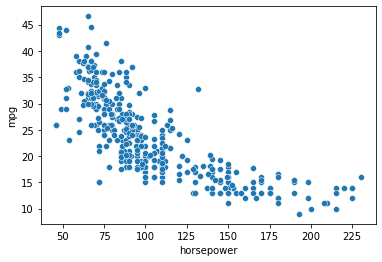

In [133]:
# polarsでは.valuesはないため、機械学習で使う場合はto_numpy()でnumpy配列に変換してreshapeする。
# Xはこの後特に使わない。
X = df_pl['horsepower'].to_numpy().reshape(-1, 1)
y = df_pl['mpg']
sns.scatterplot(x=df_pl['horsepower'], y=y)

# pandasの場合
# X = df_pa['horsepower'].values.reshape(-1, 1)
# y = df_pa['mpg']
# sns.scatterplot(x=df_pa['horsepower'], y=y)

このようなデータがあったときに一部のデータ(例えば、50 < horsepower < 75 かつ 30 < mpg < 45)だけ抜き出す、  
あるいは削除したいときは下記のようにすればよい。

In [134]:
len(df_pl)

392

In [145]:
# 不要な部分を除いて格納。is_betweenはデフォルトで指定区間の境界を含むので、除く場合はclosed='none'にすること
df_pl2 = df_pl.filter(
    ~((pl.col('horsepower').is_between(50.0, 75.0, closed='none')) &
    (pl.col('mpg').is_between(30.0, 45.0, closed='none')))
)

pandas同様にチルダでbooleanの否定ができる。  
polarsではindexはないので、特定部分だけ消したDFを定義したいのであれば、特定部分を表す条件式を書いて、  
その否定をとることで、特定部分を除いたDFを取得できる。  

In [146]:
len(df_pl2)

338

※Pandasの場合↓  
queryとindexの方が書き方的にはわかりやすいかも。  
polarsは早さのメリットがあるからしょうがないか。

In [141]:
# クエリで抽出と元データからの削除
drop_target = df_pd.query('50 < horsepower < 75 & 30 < mpg < 45').index
df_pd = df_pd.drop(index=drop_target).copy()

In [142]:
len(df_pd)

338

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

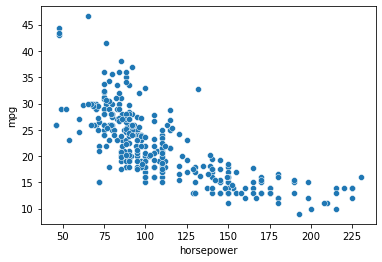

In [143]:
# polarsの場合
y = df_pl2['mpg']
sns.scatterplot(x=df_pl2['horsepower'], y=y)

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

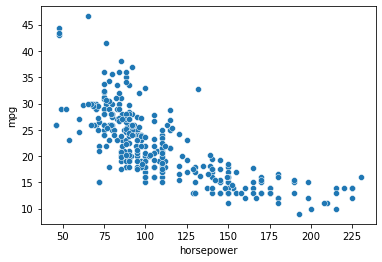

In [144]:
# pandasの場合
y = df_pd['mpg']
sns.scatterplot(x=df_pd['horsepower'], y=y)

polarsでもpandasと同様に狙った部分が消せている。  
学習データの不要な部分を削除するときなどに使える。  
polarsは少し直感的でない部分もあるが、慣れれば問題なさそう。

## ピアソンの相関係数を算出する場合の注意

In [200]:
# seabornからのデータセットはpandasのDataFrameの形
df_pl = pl.from_pandas(sns.load_dataset('mpg').dropna())

In [201]:
df_pl.head()

mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
f64,i64,f64,f64,i64,f64,i64,str,str
18.0,8,307.0,130.0,3504,12.0,70,"""usa""","""chevrolet chev..."
15.0,8,350.0,165.0,3693,11.5,70,"""usa""","""buick skylark ..."
18.0,8,318.0,150.0,3436,11.0,70,"""usa""","""plymouth satel..."
16.0,8,304.0,150.0,3433,12.0,70,"""usa""","""amc rebel sst"""
17.0,8,302.0,140.0,3449,10.5,70,"""usa""","""ford torino"""


mpg(Float64),weight(Int64)でデータ型が違うとピアソンの相関係数を算出できない模様。

In [202]:
df_pl.select(pl.pearson_corr('mpg', 'weight'))

thread '<unnamed>' panicked at 'called `Result::unwrap()` on an `Err` value: SchemaMisMatch(Owned("Series of dtype: Int64 != Float64"))', /home/runner/work/polars/polars/polars/polars-lazy/polars-plan/src/dsl/functions.rs:101:36


PanicException: called `Result::unwrap()` on an `Err` value: SchemaMisMatch(Owned("Series of dtype: Int64 != Float64"))

したがって下記のように一方のデータ型をcastする必要がある。

In [222]:
df_pl.select(pl.pearson_corr('mpg', pl.col('weight').cast(pl.Float64))).item()

-0.8322442148315756

<AxesSubplot:xlabel='mpg', ylabel='weight'>

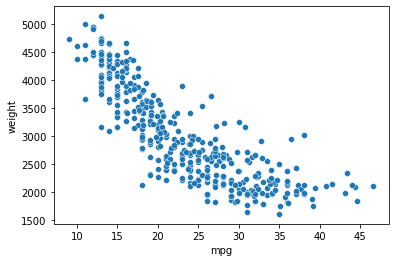

In [204]:
sns.scatterplot(x=df_pl['mpg'], y=df_pl['weight'])

確かに負の相関がある。

## Label Encoding with Polars
参考：https://zenn.dev/gamera/articles/cd0f49c8ae74f6

In [224]:
df_le = pl.read_csv('../../Python/sample_data/ML_sample/sample_data3.csv')
df_le.head()

space,rent,age,facing_direction
i64,f64,i64,str
20,13.958824,3,"""South"""
25,11.533805,13,"""South"""
28,14.269547,18,"""North"""
30,18.72268,10,"""West"""
36,19.602674,6,"""West"""


In [239]:
encode_subject = 'facing_direction'
# インスタンス生成
le = LabelEncoder()
# クラスとラベルの対応を学習。引数は1D Alleyである必要がある。複数列エンコードする場合はfor文で。
le.fit(df_le.get_column(encode_subject))
# エンコーディング。結果を元データに反映するには代入する必要あり.
# fit.transform()で一気にエンコードできる。
le.transform(df_le.get_column(encode_subject))

array([2, 2, 1, 3, 3, 2, 0, 1, 1, 3])

In [241]:
le.classes_

array(['East', 'North', 'South', 'West'], dtype=object)

In [244]:
# encode結果の格納
df_le = df_le.with_columns(
    pl.Series( le.fit_transform(df_le.get_column(encode_subject)) )
    .alias(encode_subject)
)

### 欠損値がある場合

In [2]:
df_le2 = pl.read_csv('../../Machine Learning/sample_data/LabelEncoding_missing_values.csv')

In [3]:
df_le2

ID,Price,Name,Status
i64,i64,str,str
1,100,null,"""Good"""
2,200,"""apple""",null
3,300,null,"""Bad"""
4,200,"""Lemon""",null
5,600,null,"""Normal"""


In [5]:
df_le2.null_count()

ID,Price,Name,Status
u32,u32,u32,u32
0,0,3,2


In [7]:
le = LabelEncoder()
le.fit_transform(df_le2.get_column('Status'))

array([1, 3, 0, 3, 2])

In [8]:
le.classes_

array(['Bad', 'Good', 'Normal', None], dtype=object)

pandasと同様に欠損値もエンコーディングされる。

In [11]:
# 欠損値も含めてラベルエンコーディングする
category = ['Name', 'Status']
for c in category:
    le = LabelEncoder()
    df_le2 = df_le2.with_columns(
            pl.Series( le.fit_transform(df_le2.get_column(c)) )
            .alias(c))

In [12]:
df_le2

ID,Price,Name,Status
i64,i64,i64,i64
1,100,2,1
2,200,1,3
3,300,2,0
4,200,0,3
5,600,2,2


Nameではclass=2、Statusではclass=3でエンコーディングされていることがわかる。

In [13]:
df_le2 = pl.read_csv('../../Machine Learning/sample_data/LabelEncoding_missing_values.csv')

polarsで欠損値を除いてラベルエンコーディングをするには下記のようにwhen,thenを用いる。

In [51]:
df_le2.with_columns(
    pl.when(pl.col('Name').is_not_null())
    .then( pl.Series(le.fit_transform(df_le2.get_column('Name'))).alias('Name') )
)

ID,Price,Name,Status
i64,i64,i64,str
1,100,null,"""Good"""
2,200,1,null
3,300,null,"""Bad"""
4,200,0,null
5,600,null,"""Normal"""


In [53]:
# 欠損値を除いてラベルエンコーディングする場合
for col in category:
    le = LabelEncoder()
    le_expr = pl.Series(le.fit_transform(df_le2.get_column(col))).alias(col)
    
    # nullでない行にのみラベルエンコーディングを適用する
    df_le2 = df_le2.with_columns(
                pl.when(pl.col(col).is_not_null())
                .then(le_expr)
    )
    # ↓pandasの場合
    #notnull = df_le2.filter(pl.col(col).is_not_null()).select(col).to_series()
    # fit_transformの戻り値はnumpy arrayであるため、
    # そのまま代入することはできないので、pd.SeriesでSeriesに変更してから代入する。
    # この場合、indexは0から裁判されるため、元々のデータのindexとずれてしまい、index=0から配列長までしか代入されず、残りはNaNになってしまう。
    # これを防ぐためにpd.Seriesで元のindexと揃えて代入する
    #df2[col] = pd.Series(le.fit_transform(notnull), index=notnull.index)

In [54]:
df_le2

ID,Price,Name,Status
i64,i64,i64,i64
1,100,null,1
2,200,1,null
3,300,null,0
4,200,0,null
5,600,null,2


nullを除いてラベルエンコーディング出来ている。pandasよりも分かりやすいかも。

## ナノ秒の取り扱い
ログの分析などではナノ秒まで情報が必要な場合があるので、  
Polarsにおける取り扱い方をメモしておく。

### 時刻データが綺麗にフォーマットされている場合

In [151]:
df_ns = pl.DataFrame({'Time': 
         ['2020-01-01 00:00:00.123456789',
          '2020-01-01 00:00:00.123456790',
          '2020-01-01 00:00:00.123456791']
        })

In [152]:
pl.Config.set_fmt_str_lengths(40)
df_ns

Time
str
"""2020-01-01 00:00:00.123456789"""
"""2020-01-01 00:00:00.123456790"""
"""2020-01-01 00:00:00.123456791"""


pl.DataFrameのschemaにpl.Datetime("ns")を指定するのはダメそうだったので、  
strで一旦読み込む。  
カラムの幅が狭くてナノ秒まで見えないときはpl.Config.set_fmt_str_lengths(文字数)  で調整するとよい。  
https://pola-rs.github.io/polars/py-polars/html/reference/api/polars.Config.set_fmt_str_lengths.html

In [155]:
df_ns.get_column('Time').str.strptime(pl.Datetime("ns"))

Time
datetime[ns]
2020-01-01 00:00:00.123456789
2020-01-01 00:00:00.123456790
2020-01-01 00:00:00.123456791


ナノ秒まで含めてDatetime型に変換するには上記のように書けばよい。  
https://stackoverflow.com/questions/75119895/parse-nanoseconds-with-polars

### 数字の羅列になっている場合

In [156]:
df_ns2 = pl.DataFrame({'Time': 
         ['20200101000000123456789',
          '20200101000000123456790',
          '20200101000000123456791']
        })

In [182]:
df_ns2

Time
str
"""20200101000000123456789"""
"""20200101000000123456790"""
"""20200101000000123456791"""


In [190]:
# ナノ秒まで含めてDatetime型に変換
df_ns2.get_column('Time').str.strptime(pl.Datetime('ns'), '%Y%m%d%H%M%S%f')

Time
datetime[ns]
2020-01-01 00:00:00.123456789
2020-01-01 00:00:00.123456790
2020-01-01 00:00:00.123456791


上記のように書くことで、数字の羅列もDatetime型へ変換可能。  
フォーマットの指定には'-'や':'は不要っぽい。  
pl.Datetime('ms')などにすることで秒以下の単位を変更できる。

In [195]:
df_ns2.get_column('Time').str.strptime(pl.Datetime('ns'), '%Y%m%d%H%M%S%f').diff()

Time
duration[ns]
null
1ns
1ns


.diff()でひとつ前のレコードとの時刻差を算出できる。